In [ ]:
#import all the libraries that are needed
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving time_series_covid19_confirmed_Germany.csv to time_series_covid19_confirmed_Germany (3).csv
User uploaded file "time_series_covid19_confirmed_Germany.csv" with length 4838 bytes


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['time_series_covid19_confirmed_Germany.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
data.info() #data details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 301 entries, Province/State to 11/13/2020
dtypes: float64(3), int64(297), object(1)
memory usage: 2.5+ KB


In [ ]:
data.describe() #describing the data

,Province/State,Lat,Long,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,...,10/5/2020,10/6/2020,10/7/2020,10/8/2020,10/9/2020,10/10/2020,10/11/2020,10/12/2020,10/13/2020,10/14/2020,10/15/2020,10/16/2020,10/17/2020,10/18/2020,10/19/2020,10/20/2020,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020,11/1/2020,11/2/2020,11/3/2020,11/4/2020,11/5/2020,11/6/2020,11/7/2020,11/8/2020,11/9/2020,11/10/2020,11/11/2020,11/12/2020,11/13/2020
count,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,NaN,51.165691,10.451526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,7.0,8.0,9.0,11.0,11.0,11.0,12.0,13.0,13.0,13.0,13.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,17.0,21.0,...,300619.0,303258.0,306086.0,310144.0,314660.0,319381.0,322864.0,325331.0,329453.0,334585.0,341223.0,348557.0,356387.0,361974.0,366299.0,373167.0,380762.0,392049.0,403291.0,418005.0,429181.0,437866.0,449275.0,464239.0,481013.0,499694.0,518753.0,532930.0,545027.0,560379.0,577593.0,597583.0,619089.0,642488.0,658505.0,671868.0,687200.0,705687.0,727553.0,751095.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,51.165691,10.451526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,7.0,8.0,9.0,11.0,11.0,11.0,12.0,13.0,13.0,13.0,13.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,17.0,21.0,...,300619.0,303258.0,306086.0,310144.0,314660.0,319381.0,322864.0,325331.0,329453.0,334585.0,341223.0,348557.0,356387.0,361974.0,366299.0,373167.0,380762.0,392049.0,403291.0,418005.0,429181.0,437866.0,449275.0,464239.0,481013.0,499694.0,518753.0,532930.0,545027.0,560379.0,577593.0,597583.0,619089.0,642488.0,658505.0,671868.0,687200.0,705687.0,727553.0,751095.0
25%,NaN,51.165691,10.451526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,7.0,8.0,9.0,11.0,11.0,11.0,12.0,13.0,13.0,13.0,13.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,17.0,21.0,...,300619.0,303258.0,306086.0,310144.0,314660.0,319381.0,322864.0,325331.0,329453.0,334585.0,341223.0,348557.0,356387.0,361974.0,366299.0,373167.0,380762.0,392049.0,403291.0,418005.0,429181.0,437866.0,449275.0,464239.0,481013.0,499694.0,518753.0,532930.0,545027.0,560379.0,577593.0,597583.0,619089.0,642488.0,658505.0,671868.0,687200.0,705687.0,727553.0,751095.0
50%,NaN,51.165691,10.451526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,7.0,8.0,9.0,11.0,11.0,11.0,12.0,13.0,13.0,13.0,13.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,17.0,21.0,...,300619.0,303258.0,306086.0,310144.0,314660.0,319381.0,322864.0,325331.0,329453.0,334585.0,341223.0,348557.0,356387.0,361974.0,366299.0,373167.0,380762.0,392049.0,403291.0,418005.0,429181.0,437866.0,449275.0,464239.0,481013.0,499694.0,518753.0,532930.0,545027.0,560379.0,577593.0,597583.0,619089.0,642488.0,658505.0,671868.0,687200.0,705687.0,727553.0,751095.0
75%,NaN,51.165691,10.451526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,7.0,8.0,9.0,11.0,11.0,11.0,12.0,13.0,13.0,13.0,13.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,17.0,21.0,...,300619.0,303258.0,306086.0,310144.0,314660.0,319381.0,3

In [ ]:
data.head()

,Province/State,Country/Region,Lat,Long,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,...,10/5/2020,10/6/2020,10/7/2020,10/8/2020,10/9/2020,10/10/2020,10/11/2020,10/12/2020,10/13/2020,10/14/2020,10/15/2020,10/16/2020,10/17/2020,10/18/2020,10/19/2020,10/20/2020,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020,11/1/2020,11/2/2020,11/3/2020,11/4/2020,11/5/2020,11/6/2020,11/7/2020,11/8/2020,11/9/2020,11/10/2020,11/11/2020,11/12/2020,11/13/2020
0,NaN,Germany,51.165691,10.451526,0,0,0,0,0,0,1,4,4,5,7,8,9,11,11,11,12,13,13,13,13,15,15,15,15,15,15,15,15,15,15,15,15,15,15,17,...,300619,303258,306086,310144,314660,319381,322864,325331,329453,334585,341223,348557,356387,361974,366299,373167,380762,392049,403291,418005,429181,437866,449275,464239,481013,499694,518753,532930,545027,560379,577593,597583,619089,642488,658505,671868,687200,705687,727553,751095


In [ ]:
df = data.iloc[:,4:]
df.head()

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,...,10/5/2020,10/6/2020,10/7/2020,10/8/2020,10/9/2020,10/10/2020,10/11/2020,10/12/2020,10/13/2020,10/14/2020,10/15/2020,10/16/2020,10/17/2020,10/18/2020,10/19/2020,10/20/2020,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020,11/1/2020,11/2/2020,11/3/2020,11/4/2020,11/5/2020,11/6/2020,11/7/2020,11/8/2020,11/9/2020,11/10/2020,11/11/2020,11/12/2020,11/13/2020
0,0,0,0,0,0,0,1,4,4,5,7,8,9,11,11,11,12,13,13,13,13,15,15,15,15,15,15,15,15,15,15,15,15,15,15,17,21,47,57,111,...,300619,303258,306086,310144,314660,319381,322864,325331,329453,334585,341223,348557,356387,361974,366299,373167,380762,392049,403291,418005,429181,437866,449275,464239,481013,499694,518753,532930,545027,560379,577593,597583,619089,642488,658505,671868,687200,705687,727553,751095


In [ ]:
df.shape

(1, 297)

1/22/20 0
1/23/20 0
increment cases 0


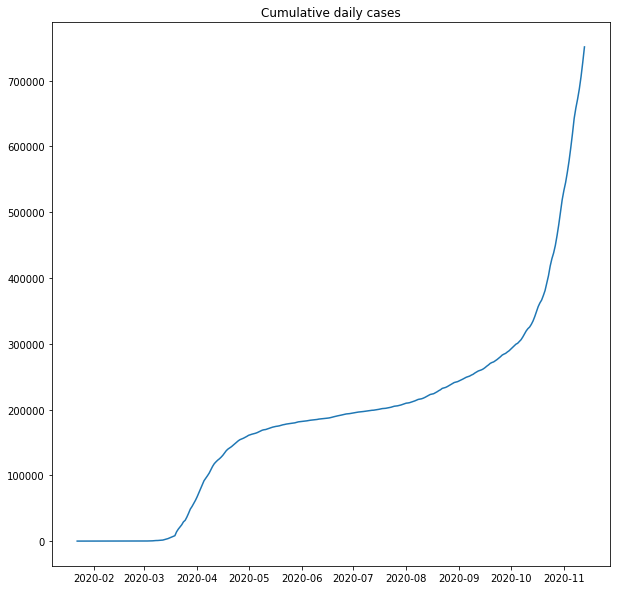

In [ ]:
# evaluate cases to increase
daily_data = df.sum(axis=0)
print('1/22/20',daily_data[0])
print('1/23/20',daily_data[1])
print('increment cases',daily_data[1]-daily_data[0])

daily_data = df.sum(axis=0)
daily_data.index = pd.to_datetime(daily_data.index)
daily_data.head()

plt.figure(figsize=(10, 10))
plt.plot(daily_data)
plt.title("Cumulative daily cases");

In [ ]:
# evaluate cases to increase

daily_data = df.sum(axis=0)
print('1/22/20',daily_data[0])
print('1/23/20',daily_data[1])
print('increment cases',daily_data[1]-daily_data[0])

daily_data = daily_data.diff().fillna(daily_data[0]).astype(np.int64)

daily_data.index = pd.to_datetime(daily_data.index)
daily_data.head()
plt.figure(figsize=(10, 10))
plt.plot(daily_data)
plt.title(" daily data");

In [ ]:
#It is better to view the data available shape and format.
daily_data.shape,
daily_data[:15]


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
2020-01-27    0
2020-01-28    1
2020-01-29    3
2020-01-30    0
2020-01-31    1
2020-02-01    2
2020-02-02    1
2020-02-03    1
2020-02-04    2
2020-02-05    0
dtype: int64

In [ ]:
mm_scaler = MinMaxScaler() #Bu aşamada ön işleme olarak 0-1 aralığına ölçeklendirerek MinMax Normalizasyonunu gerçekleştiriyoruz.
mm_scaler = mm_scaler.fit(np.expand_dims(daily_data, axis=1))
total_data = mm_scaler.transform(np.expand_dims(daily_data, axis=1))
total_data.shape

(297, 1)

In [ ]:
#giriş ve çıkış verilerimizi oluşturuyoruz(x ve y olarak)verimizi daha küçük verilere dönüştüreceğiz.
def split_sequences(sequences_data,sequence_length):
    X,y = list(),list()
    for i in range(len(sequences_data)-sequence_length-1):
        
        end_ix = i + sequence_length
        #modelin girdi ve çıktı kısımlarını toplayın
        seq_x, seq_y = sequences_data[i:(end_ix)],sequences_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
#sequence_length = 5 #previous notes of data can be remembered as 5 values
X, y = split_sequences(sequences_data=total_data, sequence_length=5)

In [ ]:
#verileri numpy dizisinden torch.tensor'a dönüştür
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).float().to(device)

In [ ]:
#Her eğitim örneği, 5geçmiş veri noktası için ve modelimizin tahmin etmesi gereken gerçek değer için bir label içerir.
X[:4],X.type(),X.shape

(tensor([[[0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [0.0000e+00]],
 
         [[0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [0.0000e+00]],
 
         [[0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [4.2477e-05]],
 
         [[0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          [4.2477e-05],
          [1.2743e-04]]]), 'torch.FloatTensor', torch.Size([291, 5, 1]))

In [ ]:

y[:10],y.type(),y.shape

(tensor([[0.0000e+00],
         [4.2477e-05],
         [1.2743e-04],
         [0.0000e+00],
         [4.2477e-05],
         [8.4955e-05],
         [4.2477e-05],
         [4.2477e-05],
         [8.4955e-05],
         [0.0000e+00]]), 'torch.FloatTensor', torch.Size([291, 1]))

In [ ]:
#modelimizi oluşturduk. modelimizin karmaşıklığınıgenişleten bir sınıfa kapsülledik. modelimiz 3 method içeriyor.
class FutureDataPrediction(nn.Module):
    def __init__(self, feature_size, hidden_layer, seq_len,layers=2):
        super(FutureDataPrediction, self).__init__()
        self.hidden_layer = hidden_layer
        self.seq_len = seq_len
        self.layers = layers
        #dropout,Overfitting yani aşırı öğrenme sorununu aşmamıza yarayan
        self.lstm = nn.LSTM(input_size=feature_size,hidden_size=hidden_layer,num_layers=layers,dropout=0.5) #dropout en basit ifade ile sistemin ezberlemesini önlemeye çalışan bir katmandır.
        self.linear = nn.Linear(in_features=hidden_layer, out_features=1)
    
    def reset_hidden_state(self): #reset_hidden ile her örnekten sonra durumu sıfırlıyoruz.
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_layer).to(device),
            torch.zeros(self.layers, self.seq_len, self.hidden_layer).to(device))
    
    def forward(self, data): #previous time stepinin outputunu alırız ve onu lineer katmandan geçiririz.
        lstm, self.hidden = self.lstm(data.view(len(data), self.seq_len, -1),self.hidden)
        previous_time_step = lstm.view(self.seq_len, len(data), self.hidden_layer)[-1]
        out = self.linear(previous_time_step)
        return out

In [ ]:
#initialise modelparameters
model = FutureDataPrediction(
    feature_size=1,
    hidden_layer=512,
    seq_len=5,
    layers=2)
#Modelin ağırlıklarını bizim için güncelleyecek bir Optimizer tanımlamak için optim paketini kullandık. 
#Burada Adam'ı kullandık; optim paketi diğer birçok optimizasyon algoritmasını içerir. 
#Adam kurucusunun ilk argümanı, optimize ediciye hangi Tensörleri güncellemesi gerektiğini söyler.
criterion = torch.nn.MSELoss(reduction='mean') #mean squared error kullandık eğitimimizi ve test hatamızı ölçmek için. 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model = model.to(device)
model

FutureDataPrediction(
  (lstm): LSTM(1, 512, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
#modelimizin eğitimi için yardımcı fonksiyonumu oluşturduk.
def training(model,X_train,y_train,n_epochs):
    model.train()
    train_losses = []
    
    for epoch in range(n_epochs):
        X_train, y_train = X_train.to(device), y_train.to(device)
        model.reset_hidden_state()
        optimizer.zero_grad() #the state has to be initialise to the start position after an epoch start.
        y_pred = model(X_train)
        loss = criterion(y_pred.float(), y_train) #ağırlıkları güncellemek için loss elde ettik.
        train_losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch} train loss: {loss.item()}')
            
        loss.backward()
        optimizer.step()
    return train_losses

In [ ]:
train_losses = training(model,X,y,n_epochs=400)

Epoch 0 train loss: 0.005645113065838814
Epoch 10 train loss: 0.0058313822373747826
Epoch 20 train loss: 0.005644187331199646
Epoch 30 train loss: 0.00548679381608963
Epoch 40 train loss: 0.005818313453346491
Epoch 50 train loss: 0.005715998355299234
Epoch 60 train loss: 0.005920860450714827
Epoch 70 train loss: 0.006020986475050449
Epoch 80 train loss: 0.005742976907640696
Epoch 90 train loss: 0.00572093715891242
Epoch 100 train loss: 0.005475560203194618
Epoch 110 train loss: 0.005200107116252184
Epoch 120 train loss: 0.005390226375311613
Epoch 130 train loss: 0.005747038871049881
Epoch 140 train loss: 0.005331152584403753
Epoch 150 train loss: 0.005807525012642145
Epoch 160 train loss: 0.005731774494051933
Epoch 170 train loss: 0.005447142757475376
Epoch 180 train loss: 0.005856796633452177
Epoch 190 train loss: 0.0057706390507519245
Epoch 200 train loss: 0.005605663172900677
Epoch 210 train loss: 0.005811025388538837
Epoch 220 train loss: 0.006016396451741457
Epoch 230 train loss: 

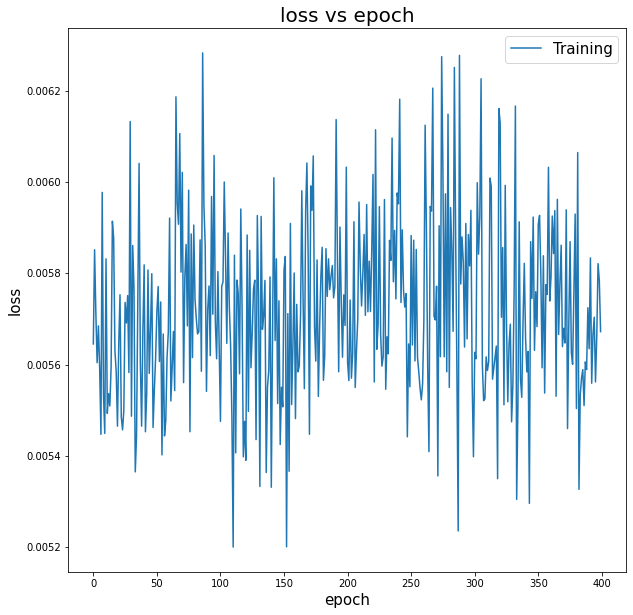

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Training')    
plt.title("loss vs epoch",fontsize=20)
plt.xlabel("epoch",fontsize=15)
plt.ylabel("loss",fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
X.shape

torch.Size([291, 5, 1])

In [ ]:
#modelimiz gelecekte yalnızca tek bir günü tahmin edebilir. bunun üstesinden gelmek için girdi olarak tahmin edilen günleri kullanacağız.
def testing(model,X,predict_days,sequence_length):
    model.eval()
    
    with torch.no_grad():
        test_sequence = X[:1] #geleceği tahmin etmek için X'in son verilerini ağa girdi olarak göndericez.
        predicts = []

        for _ in range(predict_days):
            y_pred = model(test_sequence)
            predict = torch.flatten(y_pred).item() #değerleri düzleştiriyorz 
            predicts.append(predict)
            
            test_seq = test_sequence.detach().cpu().numpy().flatten() #yeni diziye bağlanmak için eski diziyi flatten ediyoruz
            test_seq = np.append(test_seq, [predict]) #obtain new predicted as sequence
            test_seq = test_seq[1:] 
            testing_seq = torch.as_tensor(test_seq).view(1, sequence_length, 1).float()
    return predicts


In [ ]:
predict_days = 30 #önümüzdeki ayı tahmin edeceğiz
predict_cases = testing(model,X,predict_days,sequence_length = 5) 
predict_cases


[1.0756417512893677,
 0.997995913028717,
 1.2613543272018433,
 0.9749892354011536,
 1.4213212728500366,
 0.9458672404289246,
 1.4056309461593628,
 0.8693820834159851,
 1.0320481061935425,
 0.7598780989646912,
 0.8908880352973938,
 0.7196239829063416,
 0.8097901940345764,
 0.7003218531608582,
 0.7733357548713684,
 0.7247999906539917,
 0.7605200409889221,
 0.7411555647850037,
 0.7409469485282898,
 0.7338774800300598,
 0.7265216708183289,
 0.7128459811210632,
 0.700789749622345,
 0.6908461451530457,
 0.6831719279289246,
 0.6777642369270325,
 0.6746441721916199,
 0.6734101176261902,
 0.6735052466392517,
 0.6744231581687927]

In [ ]:

#0 dan 1 e değerleri minmaxscaler ile orjinal değerlere ters çeviriyoruz
future_cases = mm_scaler.inverse_transform(np.expand_dims(predict_cases, axis=0)).flatten() 
predict_index = pd.date_range(
                  start=daily_data.index[-1],
                  periods=predict_days + 1,
                  closed='right')
future_cases = pd.Series(
                  data=future_cases,
                  index=predict_index) #model tarafından oluşturulan gecelecek vakalar

In [ ]:
#önceki vakaların aynı tarih biçimde elde edilmesi
previous_index = pd.date_range(
                  start=daily_data.index[0],
                  periods=len(daily_data))
previous_cases = pd.Series(
                  data=daily_data,
                  index=previous_index)

In [ ]:
previous_cases

2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-11-09    13363
2020-11-10    15332
2020-11-11    18487
2020-11-12    21866
2020-11-13    23542
Freq: D, Length: 297, dtype: int64

In [ ]:
future_cases

2020-11-14    25322.758109
2020-11-15    23494.819785
2020-11-16    29694.803571
2020-11-17    22953.196580
2020-11-18    33460.745405
2020-11-19    22267.606574
2020-11-20    33091.363734
2020-11-21    20466.993008
2020-11-22    24296.476516
2020-11-23    17889.050206
2020-11-24    20973.286127
2020-11-25    16941.387806
2020-11-26    19064.080748
2020-11-27    16486.977067
2020-11-28    18205.870341
2020-11-29    17063.241380
2020-11-30    17904.162805
2020-12-01    17448.284306
2020-12-02    17443.373062
2020-12-03    17276.943635
2020-12-04    17103.773174
2020-12-05    16781.820088
2020-12-06    16497.992286
2020-12-07    16263.899949
2020-12-08    16083.233527
2020-12-09    15955.925666
2020-12-10    15882.473102
2020-12-11    15853.420989
2020-12-12    15855.660516
2020-12-13    15877.269990
Freq: D, dtype: float64

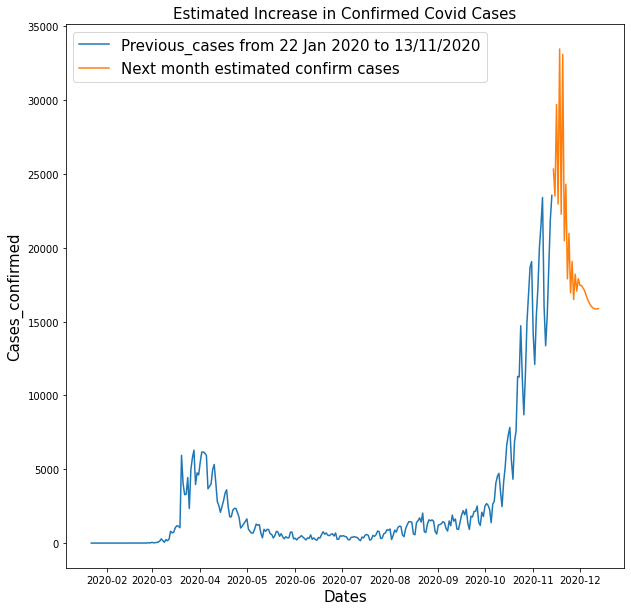

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(previous_cases, label='Previous_cases from 22 Jan 2020 to 13/11/2020')
plt.plot(future_cases, label='Next month estimated confirm cases')
plt.title("Estimated Increase in Confirmed Covid Cases",fontsize=15)
plt.xlabel("Dates",fontsize=15)
plt.ylabel("Cases_confirmed",fontsize=15)
plt.legend(fontsize=15)